In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# Đọc dữ liệu benchmark và ZAP
benchmark_df = pd.read_csv('../data/owasp/expected_results_320.csv')
zap_df = pd.read_csv('../data/zap/zap_report.csv')

# Chuẩn hóa cột benchmark
df_bench = benchmark_df.rename(columns=lambda x: x.strip())
df_bench = df_bench.rename(columns={'# test name': 'testcase', 'real vulnerability': 'real_vulnerability', 'category': 'category'})
df_bench['category'] = df_bench['category'].str.lower()
df_bench['testcase'] = df_bench['testcase'].str.strip()
df_bench = df_bench.drop(['Benchmark version: 1.2', '2016-06-1'], axis=1)

print("\n🔎 Preview df_bench:")
print(df_bench.head())


🔎 Preview df_bench:
             testcase    category  real_vulnerability  cwe
0  BenchmarkTest01025  pathtraver                True   22
1  BenchmarkTest01238  pathtraver                True   22
2  BenchmarkTest00528  pathtraver                True   22
3  BenchmarkTest00783  pathtraver                True   22
4  BenchmarkTest02378  pathtraver                True   22


In [2]:
# Mapping alert ZAP sang category benchmark
alert2cwe = {
    'Cross Site Scripting (Reflected)': 'xss',
    'Path Traversal': 'pathtraver',
    'Remote OS Command Injection': 'cmdi',
    'SQL Injection': 'sqli',
    'SQL Injection - Hypersonic SQL': 'sqli',
    'SQL Injection - SQLite': 'sqli',
    'XSLT Injection': 'xpathi'
}

zap_df['category_zap'] = zap_df['alert'].map(alert2cwe)
zap_df['testcase'] = zap_df['param']
zap_df_filtered = zap_df[zap_df['category_zap'].notna()]
zap_grouped = zap_df_filtered.groupby('testcase')['category_zap'].apply(set).reset_index()

print("\n🔎 Preview zap_df:")
print(zap_df.head())


🔎 Preview zap_df:
   pluginid                             alert  riskcode       riskdesc  \
0     40012  Cross Site Scripting (Reflected)         3  High (Medium)   
1     40012  Cross Site Scripting (Reflected)         3  High (Medium)   
2     40012  Cross Site Scripting (Reflected)         3  High (Medium)   
3     40012  Cross Site Scripting (Reflected)         3  High (Medium)   
4     40012  Cross Site Scripting (Reflected)         3  High (Medium)   

                                                 uri method  \
0  https://localhost:8443/benchmark/pathtraver-01...    GET   
1  https://localhost:8443/benchmark/pathtraver-03...    GET   
2  https://localhost:8443/benchmark/xss-00/Benchm...    GET   
3  https://localhost:8443/benchmark/xss-00/Benchm...    GET   
4  https://localhost:8443/benchmark/xss-00/Benchm...    GET   

                param                        attack  \
0  BenchmarkTest01643  ＜img src=x onerror=prompt()＞   
1  BenchmarkTest02559  ＜img src=x onerror=promp

In [3]:
# Merge với benchmark
merged_df = df_bench.merge(zap_grouped, on='testcase', how='left')
merged_df['category_zap'] = merged_df['category_zap'].apply(lambda x: x if isinstance(x, set) else set())

# Đánh giá TP, FP, FN, TN
def evaluate(row):
    category_benchmark = row['category']
    category_zap_set = row['category_zap']
    real_vuln = row['real_vulnerability']

    if real_vuln:  # Benchmark có lỗi
        if category_benchmark in category_zap_set: 
            return 'TP' # FSB báo CWE đúng category benchmark
        else:
            return 'FN' # FSB không báo category benchmark
    else:  # Benchmark không có lỗi
        if category_benchmark in category_zap_set:
            return 'FP'  # FSB báo CWE đúng category benchmark
        else:
            return 'TN'  # FSB không báo category benchmark 

merged_df['Evaluation'] = merged_df.apply(evaluate, axis=1)
print("\n🔎 Preview merged_df:")
print(merged_df.head(10))


🔎 Preview merged_df:
             testcase    category  real_vulnerability  cwe category_zap  \
0  BenchmarkTest01025  pathtraver                True   22           {}   
1  BenchmarkTest01238  pathtraver                True   22           {}   
2  BenchmarkTest00528  pathtraver                True   22           {}   
3  BenchmarkTest00783  pathtraver                True   22       {sqli}   
4  BenchmarkTest02378  pathtraver                True   22           {}   
5  BenchmarkTest01496  pathtraver                True   22           {}   
6  BenchmarkTest02561  pathtraver                True   22           {}   
7  BenchmarkTest01111  pathtraver                True   22           {}   
8  BenchmarkTest00698  pathtraver                True   22           {}   
9  BenchmarkTest00216  pathtraver                True   22           {}   

  Evaluation  
0         FN  
1         FN  
2         FN  
3         FN  
4         FN  
5         FN  
6         FN  
7         FN  
8         FN  
9 

In [4]:
# 🌿 Tạo file CSV chuẩn từ merged_df (format chuẩn để so sánh multi-tool)
zap_output_rows = []
for _, row in merged_df.iterrows():
    testcase = row['testcase']
    cwe = row['category']
    expected = bool(row['real_vulnerability'])
    detected = cwe in row['category_zap']
    zap_output_rows.append({
        'TestCase': testcase,
        'CWE': cwe,
        'Expected': expected,
        'Detected': detected
    })

zap_output_df = pd.DataFrame(zap_output_rows)

# Lưu file CSV chuẩn (cho ZAP)
zap_output_df.to_csv('../data/zap/zap_results_format.csv', index=False)
print(f"\n✅ Đã xuất file ZAP chuẩn từ merged_df")
print(zap_output_df.head())

# Tính tổng TP, FP, FN, TN
summary = merged_df['Evaluation'].value_counts().reindex(['TP', 'FP', 'FN', 'TN'], fill_value=0).reset_index()
summary.columns = ['Metric', 'Count']
print("\n📊 Summary TP, FP, FN, TN:")
print(summary)


✅ Đã xuất file ZAP chuẩn từ merged_df
             TestCase         CWE  Expected  Detected
0  BenchmarkTest01025  pathtraver      True     False
1  BenchmarkTest01238  pathtraver      True     False
2  BenchmarkTest00528  pathtraver      True     False
3  BenchmarkTest00783  pathtraver      True     False
4  BenchmarkTest02378  pathtraver      True     False

📊 Summary TP, FP, FN, TN:
  Metric  Count
0     TP     34
1     FP      0
2     FN    126
3     TN    160


In [5]:
TP = summary.loc[summary['Metric'] == 'TP', 'Count'].values[0] if 'TP' in summary['Metric'].values else 0
FP = summary.loc[summary['Metric'] == 'FP', 'Count'].values[0] if 'FP' in summary['Metric'].values else 0
FN = summary.loc[summary['Metric'] == 'FN', 'Count'].values[0] if 'FN' in summary['Metric'].values else 0
TN = summary.loc[summary['Metric'] == 'TN', 'Count'].values[0] if 'TN' in summary['Metric'].values else 0

# Tính các chỉ số
def metrics_paper(tp, fp, fn, tn):
    rec = tp / (tp + fn) if tp + fn else 0.0
    prec = tp / (tp + fp) if tp + fp else 0.0
    fpr = fp / (tn + fp) if tn + fp else 0.0

    # F–scores (β = 1, 0.5, 1.5)
    fbeta = lambda b: (1 + b**2) * prec * rec / (b**2 * prec + rec) if (prec + rec) else 0.0
    f1, f05, f15 = fbeta(1), fbeta(0.5), fbeta(1.5)

    # Markedness (TPR+TNR centered)
    denom_mark = math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    mark = ((tp * tn) - (fp * fn)) / denom_mark if denom_mark else 0.0
    
    # Informedness (Youden J)
    inf = rec - fpr

    results = {
        "Rec":  rec,
        "FPR":  fpr,
        "Prec": prec,
        "F-Mes": f1,
        "F0.5": f05,
        "F1.5": f15,
        "Mark": mark,
        "Inf":  inf,
    }

    print("\n=== KẾT QUẢ ===")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")

    return results

metrics = metrics_paper(TP, FP, FN, TN)


=== KẾT QUẢ ===
Rec: 0.2125
FPR: 0.0000
Prec: 1.0000
F-Mes: 0.3505
F0.5: 0.5743
F1.5: 0.2805
Mark: 0.3448
Inf: 0.2125


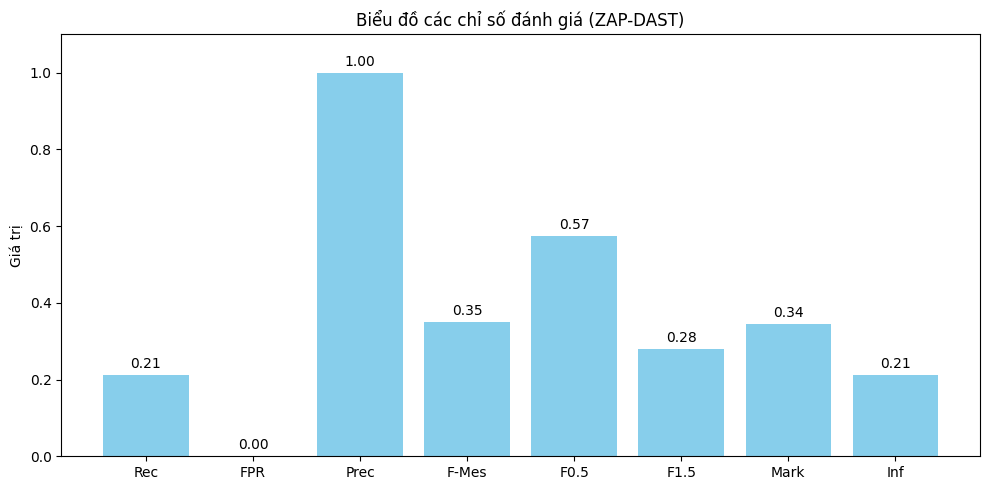

In [6]:
# Vẽ biểu đồ
labels, values = list(metrics.keys()), list(metrics.values())
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(labels, values, color='skyblue')
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
ax.set_ylim(0, 1.1)
ax.set_ylabel('Giá trị')
ax.set_title('Biểu đồ các chỉ số đánh giá (ZAP-DAST)')
plt.tight_layout()
plt.show()
